# DS 5001 Module 12 Lab: Sentiment and Significance

In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

import scipy as sp
import scipy.fftpack as fftpack

In [4]:
sns.set()

In [2]:
corpusdb = sqlite3.connect('data_out/tokens-salex.db')

In [182]:
cfg = dict(figsize=(5,1), legend=False)

In [162]:
def get_dct_transform(raw_values, 
                      low_pass_size=5, 
                      x_reverse_len=100,
                      dct_type=3):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = dct_type) # 2 or 3 works well
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return dct_out

In [178]:
def plot_dct(X, title=None, low_pass_size=5, x_reverse_len=100, dct_type=3):
    X = get_dct_transform(X.values, low_pass_size=low_pass_size, x_reverse_len=x_reverse_len, dct_type=dct_type)
    X = (X - X.mean()) / X.std()
    ax = pd.Series(X).plot(**cfg);
#     ax.set_title(title, fontsize=14)

In [179]:
def plot_roll(X, title=None, win_type='cosine', win_div=3, agg='mean'):
    window = round(X.shape[0]/win_div)
    ax = X.reset_index(drop=True).rolling(window, win_type=win_type).mean().plot(**cfg)
#     ax.set_title(title, fontsize=14)

In [180]:
def plot_raw(X, title=None):
    ax = X.plot(**cfg)
#     ax.set_title(title, fontsize=14)

In [170]:
def get_sents(book_id, bag='sent'):
    
    global LIB
    
    print(LIB.loc[book_id].title, 'by', bag)
    
    ohco = ['book_id','chap_num','para_num','sent_num']
    ohco_bag = {
        'sent': ohco,
        'para': ohco[:3],
        'chap': ohco[:2]
    }
    
    table = f"tfidf_book_{bag}_am"
    sql_x = f"select * from {table} left join salex using(term_str) where book_id = ?"

    dfx = pd.read_sql(sql_x, corpusdb, params=(book_id,))
    emo_cols = dfx.columns.to_list()[-12:]        
    dfx = dfx.set_index(ohco_bag[bag])
    
    # Format numbers
    dfx[emo_cols] = dfx[emo_cols].fillna(0)
    for col in emo_cols:
        dfx.loc[dfx[col] == '', col] = 0.0
        dfx[col] = dfx[col].astype('float')

    # Compute nrc (why now?)
    dfx['nrc_sentiment'] = dfx.nrc_positive - dfx.nrc_negative
    emo_cols = emo_cols + ['nrc_sentiment']
        
    # Compute agg stats
    dfx2 = dfx[emo_cols].multiply(dfx['tfidf'], axis="index")
    A = dfx.groupby(ohco_bag[bag])[emo_cols].agg(['mean','sum'])
    B = dfx2.groupby(ohco_bag[bag])[emo_cols].agg(['mean','sum'])

    # Combine dataframes
    A = A.T.reset_index()
    B = B.T.reset_index()
    A['type'] = 'raw'
    B['type'] = 'weighted'
    A = A.set_index(['type','level_0','level_1']).T
    B = B.set_index(['type','level_0','level_1']).T
    C = pd.concat([A,B], 1)
    
    return C

In [171]:
LIB = pd.read_sql("select * from lib", corpusdb, index_col='book_id')

In [172]:
LIB[LIB.corpus=='austen-melville']

,author,title,corpus
book_id,,,
158,austen,Emma,austen-melville
946,austen,Lady Susan,austen-melville
1212,austen,Love And Freindship And Other Early Works,austen-melville
141,austen,Mansfield Park,austen-melville
121,austen,Northanger Abbey,austen-melville
105,austen,Persuasion,austen-melville
1342,austen,Pride and Prejudice,austen-melville
161,austen,Sense and Sensibility,austen-melville
15422,melville,Israel Potter,austen-melville


In [173]:
M = {}
for bid in ['105','121','1342','2701']:
    M[bid] = get_sents(bid)

Persuasion by sent
Northanger Abbey by sent
Pride and Prejudice by sent
Moby Dick; or The Whale by sent


In [144]:
# M['105'].sum().sort_values().plot.barh(figsize=(5,20))

In [176]:
book_id = '2701'
a = M[book_id][('raw','nrc_sentiment','mean')]
b = M[book_id][('weighted','nrc_sentiment','mean')]

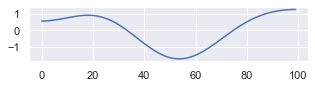

In [183]:
plot_dct(a)

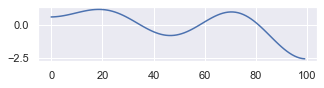

In [184]:
plot_dct(b)

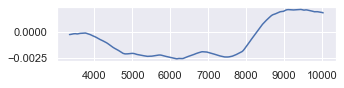

In [185]:
plot_roll(a)

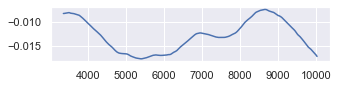

In [186]:
plot_roll(b)

In [155]:
book_id = '105'
a = M[book_id][('raw','nrc_sentiment','mean')]
b = M[book_id][('weighted','nrc_sentiment','mean')]

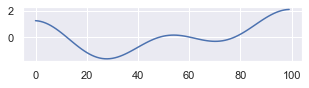

In [156]:
plot_dct(a)

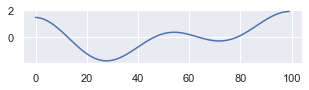

In [157]:
plot_dct(b)

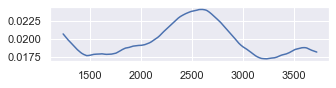

In [158]:
plot_roll(a)

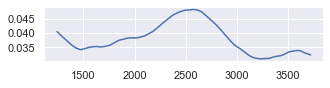

In [159]:
plot_roll(b)